In [2]:


import os
import json
import tempfile
from typing import Annotated, Literal, TypedDict, List, Dict, Any
import re

# Environment and Document Libraries
from dotenv import load_dotenv
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle

from docx import Document

# LangChain & LangGraph Core
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool

# LLMs and Tools
from langchain_groq import ChatGroq
from langchain_community.tools.pubmed.tool import PubmedQueryRun
from langchain_community.tools.tavily_search import TavilySearchResults

# Load environment variables from .env file
load_dotenv()
print("Libraries imported and environment loaded.")

Libraries imported and environment loaded.


In [3]:
# This TypedDict defines the structure of our application's state.
# It's the central memory that all agents share and can modify.

class AgentState(TypedDict):
    messages: Annotated[list[Any], "The messages in the conversation"]
    original_query: str
    research_results: Dict[str, Any]
    # A list to keep track of which researchers have already run to avoid infinite loops.
    completed_researchers: List[str]
    # The final combined report text generated by the reporting node.
    report: str
    # The final output string containing file paths of the generated documents.
    final_output: str
    # A field to hold the decision from the reflection node about which agent to run next.
    next_agent: str

In [4]:
# We initialize our LLM and all the tools the agents will need.

# LLM from Groq - fast and capable for agentic tasks.
# llm = ChatGroq(model="gemma2-9b-it", temperature=0)
llm = ChatGroq(model="qwen/qwen3-32b", temperature=0)

# Research Tools
pubmed_tool = PubmedQueryRun()
tavily_tool = TavilySearchResults(max_results=3, search_depth="advanced")

@tool
def create_pdf_tool(title: str, content: str) -> str:
    """
    Creates a PDF document, parsing structural and inline Markdown (Headers, Bold, Italic)
    into formatted PDF elements. Saves to a predictable 'output' folder.
    Returns the file path.
    """
    try:
        # makedirs the output directory 
        output_dir = "output"
        os.makedirs(output_dir, exist_ok=True)
        
        # Create a unique filename within the output directory
        # Using a timestamp ensures uniqueness for multiple runs
        from datetime import datetime
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        safe_title = "".join([c for c in title if c.isalnum() or c in (' ', '.', '_')]).replace(' ', '_')[:50]
        file_name = f"{safe_title}_{timestamp}.pdf"
        file_path = os.path.join(output_dir, file_name)

        doc = SimpleDocTemplate(file_path, pagesize=letter)
        styles = getSampleStyleSheet()

        bullet_style = ParagraphStyle(
            'BulletStyle',
            parent=styles['Normal'],
            leftIndent=18,
            firstLineIndent=0,
            spaceBefore=3,
        )

        story = [Paragraph(title, styles['Title']), Spacer(1, 12)]

        for line in content.split('\n'):
            line = line.strip()
            if not line: continue

            if line.startswith('===') and line.endswith('==='):
                story.append(Paragraph(line.strip('=').strip(), styles['h1']))
            elif line.startswith('---') and line.endswith('---'):
                story.append(Paragraph(line.strip('-').strip(), styles['h2']))
            elif line.startswith('### '):
                story.append(Paragraph(line.lstrip('# ').strip(), styles['h3']))
            elif line.startswith('- ') or line.startswith('* '):
                bullet_text = "• " + line[2:]
                formatted_line = re.sub(r'\*\*(.*?)\*\*', r'<b>\1</b>', bullet_text)
                formatted_line = re.sub(r'\*(.*?)\*', r'<i>\1</i>', formatted_line)
                story.append(Paragraph(formatted_line, bullet_style))
            else:
                formatted_line = re.sub(r'\*\*(.*?)\*\*', r'<b>\1</b>', line)
                formatted_line = re.sub(r'\*(.*?)\*', r'<i>\1</i>', formatted_line)
                story.append(Paragraph(formatted_line, styles['Normal']))
            
            story.append(Spacer(1, 6))
                
        doc.build(story)
        return f"Successfully created PDF: {os.path.abspath(file_path)}" 
    except Exception as e:
        return f"PDF creation failed: {e}"


@tool
def create_word_tool(title: str, content: str) -> str:
    """
    Creates a Word document, parsing structural Markdown into Word's
    native heading styles. Saves to a predictable 'output' folder.
    Returns the file path.
    """
    try:
        output_dir = "output"
        os.makedirs(output_dir, exist_ok=True)

        from datetime import datetime
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        safe_title = "".join([c for c in title if c.isalnum() or c in (' ', '.', '_')]).replace(' ', '_')[:50]
        file_name = f"{safe_title}_{timestamp}.docx"
        file_path = os.path.join(output_dir, file_name)

        doc = Document()
        doc.add_heading(title, 0) 

        for line in content.split('\n'):
            line = line.strip()
            if not line:
                continue

            if line.startswith('===') and line.endswith('==='):
                doc.add_heading(line.strip('=').strip(), level=1)
            elif line.startswith('---') and line.endswith('---'):
                doc.add_heading(line.strip('-').strip(), level=2)
            elif line.startswith('### '):
                doc.add_heading(line.lstrip('# ').strip(), level=3)
            elif line.startswith('- ') or line.startswith('* '):
                clean_line = line.replace('**', '').replace('*', '')
                doc.add_paragraph(clean_line, style='List Bullet')
            else:
                clean_line = line.replace('**', '').replace('*', '')
                doc.add_paragraph(clean_line)

        doc.save(file_path)
        return f"Successfully created Word document: {os.path.abspath(file_path)}" # Return absolute path
    except Exception as e:
        return f"Word creation failed: {e}"

print("LLM and Tools initialized.")




LLM and Tools initialized.


In [5]:

# --- Specialized Agents ---
team3_medical_agent = create_react_agent(llm, [pubmed_tool])
team4_financial_agent = create_react_agent(llm, [tavily_tool])

# --- Reflection Agent and its Tools ---
@tool
def continue_research(next_researcher: Literal["medical_researcher", "financial_researcher"]) -> str:
    """Decides to continue research with another specialist to get more information."""
    return f"CONTINUE:{next_researcher}"

@tool
def complete_research() -> str:
    """Decides that the research is sufficient and is ready for the reporting phase."""
    return "COMPLETE"

reflection_agent = create_react_agent(llm, [continue_research, complete_research])

# --- Initial Router to Kick Off the Process ---
@tool
def initial_research_router(topic: Literal["medical_researcher", "financial_researcher"]) -> str:
    """Selects the best initial researcher to consult for a given query."""
    return topic

initial_router_llm = llm.bind_tools([initial_research_router])

print("Agents and Routers defined.")

Agents and Routers defined.


In [6]:
# These functions are the building blocks of our graph. Each represents a node or a step in the process.

def initial_router_node(state: AgentState) -> Dict[str, Any]:
    """
    This is the first step. It analyzes the user's query and decides which
    research specialist should be consulted first.
    """
    print("--- 👑 Supervisor is choosing the first researcher ---")
    query = state["original_query"]
    # The prompt guides the LLM to use the tool correctly.
    prompt = f"Choose the best single initial researcher for this query: '{query}'"
    result = initial_router_llm.invoke(prompt)
    
    # Default to financial researcher if the LLM fails to choose a tool.
    if not result.tool_calls:
        print("--- Supervisor could not decide, defaulting to financial researcher ---")
        return {"next_agent": "financial_researcher"}
        
    chosen_researcher = result.tool_calls[0]['args']['topic']
    print(f"--- Supervisor's choice: {chosen_researcher} ---")
    return {"next_agent": chosen_researcher}


def medical_research_node(state: AgentState) -> Dict[str, Any]:
    """
    The medical specialist node. It uses the PubMed tool to perform research
    and adds its findings and its own name to the state.
    """
    print("--- 👨‍⚕️ Medical Researcher at work ---")
    result = team3_medical_agent.invoke({"messages": state["messages"]})
    
    # Update the research results
    research_results = state.get("research_results", {})
    research_results["medical"] = result["messages"][-1].content
    
    # Mark this researcher as complete to avoid running it again
    completed = state.get("completed_researchers", [])
    if "medical_researcher" not in completed:
        completed.append("medical_researcher")
    
    return {"research_results": research_results, "completed_researchers": completed}


def financial_research_node(state: AgentState) -> Dict[str, Any]:
    """
    The financial specialist node. It uses the Tavily tool to perform research
    and adds its findings and its own name to the state.
    """
    print("--- 💰 Financial Researcher at work ---")
    result = team4_financial_agent.invoke({"messages": state["messages"]})
    
    # Update the research results
    research_results = state.get("research_results", {})
    research_results["financial"] = result["messages"][-1].content
    
    # Mark this researcher as complete
    completed = state.get("completed_researchers", [])
    if "financial_researcher" not in completed:
        completed.append("financial_researcher")
        
    return {"research_results": research_results, "completed_researchers": completed}


def reflection_node(state: AgentState) -> Dict[str, Any]:
    """
    This is the core of the intelligent loop. It reviews the collected research
    and decides whether more research is needed or if it's time to report.
    """
    print("--- 🤔 Reviewer is reflecting on the results ---")
    original_query = state["original_query"]
    research_results = state["research_results"]
    completed_researchers = state["completed_researchers"]
    
    # Determine which researchers are still available.
    all_researchers = ["medical_researcher", "financial_researcher"]
    available_researchers = [r for r in all_researchers if r not in completed_researchers]
    
    prompt = f"""
    The user's original query was: "{original_query}"

    So far, the following research has been gathered:
    {json.dumps(research_results, indent=2)}

    The following researchers have already contributed: {completed_researchers}

    Based on the query and the research, is the information sufficient to create a complete report?

    - If YES, the research is complete. Use the `complete_research` tool.
    - If NO, and there are researchers available to consult ({available_researchers}), choose the best one to consult next using the `continue_research` tool.
    - If NO, but there are no more researchers available, you must use the `complete_research` tool as we have to proceed with the information we have.
    """
    
    result = reflection_agent.invoke({"messages": [HumanMessage(prompt)]})
    decision = result["messages"][-1].content
    
    # Parse the agent's decision to control the loop
    if "CONTINUE" in decision:
        next_agent = decision.split(":")[1]
        # Ensure we don't route to an unavailable agent
        if next_agent in available_researchers:
            print(f"--- Reflector Decision: Continue with {next_agent} ---")
            return {"next_agent": next_agent}

    print("--- Reflector Decision: Research is complete, proceeding to reporting ---")
    return {"next_agent": "reporting_node"}


def reporting_node(state: AgentState) -> Dict[str, Any]:
    """
    This node takes all the final research and formats it into a single,
    comprehensive text block for the document creation step.
    """
    print("--- 📝 Report Generator at work ---")
    report_text = f"Final Report for Query: {state['original_query']}\n\n"
    report_text += "=== EXECUTIVE SUMMARY & FINDINGS ===\n\n"
    
    # format the JSON research results into the report string
    for researcher, findings in state.get("research_results", {}).items():
        report_text += f"--- {researcher.replace('_', ' ').title()} ---\n"
        report_text += f"{findings}\n\n"
        
    return {"report": report_text}


def document_creation_node(state: AgentState) -> Dict[str, Any]:
    """
    The final step. This node uses the generated report text to create
    both a PDF and a Word document by calling the tools directly for reliability.
    """
    print("--- 📄 Document Creator at work (Direct Calling) ---")
    document_title = f"Research Report: {state['original_query']}"
    content = state['report']
    
    # Call tools directly to avoid LLM errors
    pdf_result = create_pdf_tool.invoke({
        "title": document_title,
        "content": content
    })
    
    word_result = create_word_tool.invoke({
        "title": document_title,
        "content": content
    })
    
    final_output_str = f"Document generation complete.\n- {pdf_result}\n- {word_result}"
    
    return {"final_output": final_output_str}

print("Node functions defined.")

Node functions defined.


In [7]:
# define the graph structure and wire all the nodes together.

workflow = StateGraph(AgentState)

# Add all the nodes to the graph
workflow.add_node("initial_router", initial_router_node)
workflow.add_node("medical_researcher", medical_research_node)
workflow.add_node("financial_researcher", financial_research_node)
workflow.add_node("reflection_node", reflection_node)
workflow.add_node("reporting_node", reporting_node)
workflow.add_node("document_creation_node", document_creation_node)

# Set the entry point of the graph
workflow.set_entry_point("initial_router")

# Define the conditional routing logic
def route_after_initial_router(state: AgentState) -> str:
    """Routes to the first researcher chosen by the supervisor."""
    return state["next_agent"]

def route_after_reflection(state: AgentState) -> str:
    """
    Determines the next step after the reflection node has made a decision.
    This can either loop back to another researcher or proceed to reporting.
    """
    next_agent = state["next_agent"]
    if next_agent == "reporting_node":
        return "proceed_to_reporting"
    else:
        return "continue_research"

# Wire the edges
# The initial router decides which researcher to call first.
workflow.add_conditional_edges(
    "initial_router",
    route_after_initial_router,
    {
        "medical_researcher": "medical_researcher",
        "financial_researcher": "financial_researcher",
    }
)

# After any research node finishes, it always goes to the reflection node to be reviewed.
workflow.add_edge("medical_researcher", "reflection_node")
workflow.add_edge("financial_researcher", "reflection_node")

# The reflection node is the heart of the loop.
workflow.add_conditional_edges(
    "reflection_node",
    route_after_reflection,
    {
        # If the decision is to continue, this edge maps the next agent's name
        # to the correct node, creating the loop.
        "continue_research": "initial_router", # Go back to the router to select the next researcher
        # If the decision is to proceed, we move to the reporting phase.
        "proceed_to_reporting": "reporting_node",
    }
)

# The reporting phase is a straight line to the end.
workflow.add_edge("reporting_node", "document_creation_node")
workflow.add_edge("document_creation_node", END)


# Compile the graph into a runnable application.
# The MemorySaver allows the graph to be stateful and remember conversation history.
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

print("Graph compiled successfully!")


Graph compiled successfully!


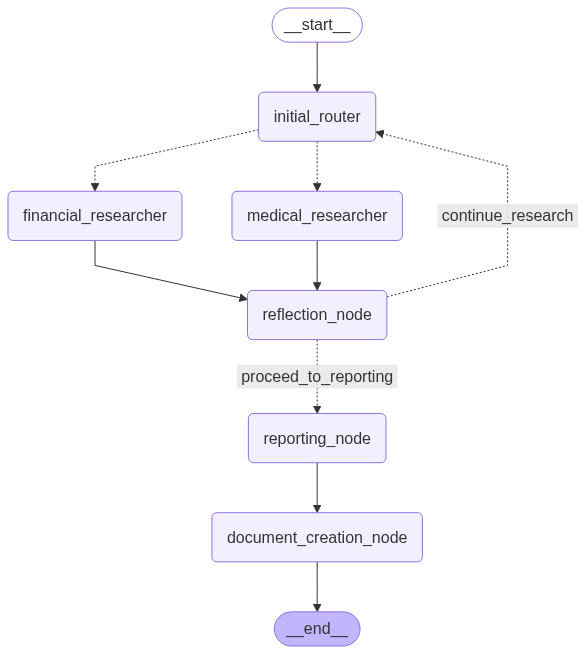

In [8]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
# The complex query that requires both medical and financial research.
complex_query = "Analyze the market impact of new Alzheimer's drug treatments on pharmaceutical companies"

# The config for this specific run. The thread_id ensures this conversation is isolated.
config = {"configurable": {"thread_id": "reflective-loop-run-1"}}

# The initial state for the graph.
initial_state = {
    "messages": [HumanMessage(content=complex_query)],
    "original_query": complex_query,
    "research_results": {},
    "completed_researchers": [],
    "report": "",
    "final_output": ""
}

print(f"--- Running Query: '{complex_query}' ---")
print("--- Watching the Reflective Loop in Action ---")

try:
    # Use app.stream() to see the output from each node as it executes.
    for event in app.stream(initial_state, config=config, stream_mode="values"):
        print("\n" + "="*50)
        print(f"Node Output:\n{json.dumps(event, indent=2, default=str)}")
        print("="*50)

    final_state = app.get_state(config)
    
    print("\n\n--- ✅ Process Complete ---")
    print("Final Research Results Gathered:")
    print(json.dumps(final_state.values['research_results'], indent=2))
    print("\nFinal Report Text:")
    print(final_state.values['report'])
    print("\nFinal Output (Document Paths):")
    print(final_state.values['final_output'])

except Exception as e:
    print(f"\n--- 🚨 An Error Occurred ---")
    print(f"Error: {e}")


--- Running Query: 'Analyze the market impact of new Alzheimer's drug treatments on pharmaceutical companies' ---
--- Watching the Reflective Loop in Action ---

Node Output:
{
  "messages": [
    "content=\"Analyze the market impact of new Alzheimer's drug treatments on pharmaceutical companies\" additional_kwargs={} response_metadata={}"
  ],
  "original_query": "Analyze the market impact of new Alzheimer's drug treatments on pharmaceutical companies",
  "research_results": {},
  "completed_researchers": [],
  "report": "",
  "final_output": ""
}
--- 👑 Supervisor is choosing the first researcher ---
--- Supervisor's choice: financial_researcher ---

Node Output:
{
  "messages": [
    "content=\"Analyze the market impact of new Alzheimer's drug treatments on pharmaceutical companies\" additional_kwargs={} response_metadata={}"
  ],
  "original_query": "Analyze the market impact of new Alzheimer's drug treatments on pharmaceutical companies",
  "research_results": {},
  "completed_rese